# Applied Data Science Capstone
This notebook is the implementation of the Coursera Applied Data Science Capstone course project.
## Segmenting and Clustering Tesla Superchargers in the United States
### Introduction
Electric cars are the future of ground transportation. Aside from being better for the environment, they are faster, quieter, less expensive to power, accelerate more smoothly, and are more reliable than their internal combustion engine (ICE) counterparts. There is, however, a nontrivial drawback to electric vehicles (EVs): charging time. This is a non-issue for daily commuting because charging can occur overnight at the owner’s home. Charging time can be an issue for trips requiring a charge before returning home though. For example, a 700-mile trip that took me 11 hours in my ICE vehicle now takes 12.5 hours in my EV, due to the extra time it takes to charge the EV as compared to filling up the ICE vehicle’s gas tank.

Taking a road trip in an EV requires a mindset shift. If completing the road trip as fast as possible is paramount, then the EV will probably leave you frustrated. If you don’t mind spending a little more time traveling and are able to leverage the charging breaks as an opportunity to stretch out, grab a snack or beverage, have lunch, chat with fellow EV travelers, or check out some of the nearby shops or attractions, then you will likely find road trips more enjoyable and reach your destination more relaxed in an EV than in an ICE vehicle.

In order to mitigate the inconvenience of charging time and further encourage the adoption of electric vehicles, this project will categorize fast charging stations according to nearby locations (e.g., fast food, coffee, groceries, park, …). Such a categorization will be useful to those planning a road trip, enabling selection of routes or charging stations along the route which have amenities of interest. Further, such a categorization may be useful to entrepreneurs interested in opening a business near chargers which do not already have a similar business nearby.

Let's start by downloading dependencies

In [1]:
import pandas as pd # library for data analysis
import requests # library to handle requests
import numpy as np # library to handle data in a vectorized manner

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans # import KMeans for clustering stage

!conda install -c conda-forge geocoder --yes
import geocoder # import geocoder

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geocoder:        1.38.1-py_1       conda-forge
    python_abi:    

### Get the charging station info and put it into a DataFrame
Limiting to Tesla US, though this could easily be expanded to include other DC fast chargers as well.

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
url = 'https://developer.nrel.gov/api/alt-fuel-stations/v1.json?api_key=' + NREL_KEY + \
    '&status=E&fuel_type=ELEC&ev_network=Tesla&country=US'
results = requests.get(url).json()

Build DataFrame with columns of interest: id, station_name, latitude, longitude, city, state, zip

In [4]:
df = json_normalize(results['fuel_stations'])
df.head()

,access_code,access_days_time,access_days_time_fr,access_detail_code,bd_blends,bd_blends_fr,cards_accepted,city,cng_dispenser_num,cng_fill_type_code,...,open_date,owner_type_code,plus4,state,station_name,station_phone,status_code,street_address,updated_at,zip
0,public,24 hours daily; for Tesla use only,None,None,None,None,None,Athens,None,None,...,2017-09-01,P,None,AL,FAIRFIELD INN - Tesla Supercharger,877-798-3752,E,21282 Athens-Limestone Blvd.,2020-02-06T19:50:43Z,35613
1,public,24 hours daily; for Tesla use only,None,None,None,None,None,Auburn,None,None,...,2015-01-01,P,None,AL,Auburn Mall - Tesla Supercharger,877-798-3752,E,1627 Opelika Road,2020-02-06T19:50:43Z,36830
2,public,24 hours daily; for Tesla use only,None,None,None,None,None,Birmingham,None,None,...,2016-12-01,P,None,AL,Uptown Entertainment District - Tesla Supercha...,877-798-3752,E,2221 Richard Arrington Junior Blvd.,2020-02-06T19:50:43Z,35203
3,public,24 hours daily; for Tesla use only,None,None,None,None,None,Greenville,None,None,...,2015-01-01,P,None,AL,Hampton Inn Greenville - Tesla Supercharger,877-798-3752,E,219 Interstate Drive,2020-02-06T19:50:43Z,36037
4,public,24 hours daily; for Tesla use only,None,None,None,None,None,Mobile,None,None,...,2015-03-01,P,None,AL,The Bel Air Mall - Tesla Supercharger,877-798-3752,E,3201 Airport Blvd,2020-02-06T19:50:43Z,36606


In [5]:
df_cs = df.loc[:, ['id', 'station_name', 'latitude', 'longitude', 'street_address', 'city', 'state', 'zip']]
df_cs.head()

,id,station_name,latitude,longitude,street_address,city,state,zip
0,101972,FAIRFIELD INN - Tesla Supercharger,34.785416,-86.942864,21282 Athens-Limestone Blvd.,Athens,AL,35613
1,101973,Auburn Mall - Tesla Supercharger,32.627837,-85.445105,1627 Opelika Road,Auburn,AL,36830
2,101974,Uptown Entertainment District - Tesla Supercha...,33.525826,-86.807072,2221 Richard Arrington Junior Blvd.,Birmingham,AL,35203
3,101975,Hampton Inn Greenville - Tesla Supercharger,31.855989,-86.635765,219 Interstate Drive,Greenville,AL,36037
4,101976,The Bel Air Mall - Tesla Supercharger,30.671556,-88.118644,3201 Airport Blvd,Mobile,AL,36606


In [6]:
df_cs.shape

(800, 8)

## Use for Foursquare API to get nearby venues for each charging station

Given a list of station IDs, latitudes, and longitudes, use for Foursquare API to get nearby venues for each, within a default radius of 400 meters, returning a DataFrame with all nearby venues for all stations

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
def getNearbyVenues(sids, latitudes, longitudes, radius=400):
    
    VERSION = '20180605' # Foursquare API version
    LIMIT = 100 # Max venues to return

    venues_list=[]
    for sid, lat, lng in zip(sids, latitudes, longitudes):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Get the Foursquare items info for each of the nearby venues
        results = requests.get(url).json()
        if (results['meta']['code'] != 200):
            print(results)
        venue_results = results['response']['groups'][0]['items']
        
        # Append a row for each nearby venue, including the location name, latitude, and longitude
        # along with the venue name, latitude, longitude, and category name.
        venues_list.append([(
            sid, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station ID', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Call getNearbyVenues on each charging station to create a new dataframe with a row for each venue within each charging station.

In [9]:
station_venues = getNearbyVenues(sids=df_cs['id'], latitudes=df_cs['latitude'], longitudes=df_cs['longitude'])

Check out how many venues were returned and look at the first few rows of the resultant DataFrame.

In [10]:
print(station_venues.shape)
station_venues.head()

(19562, 7)


,Station ID,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,101972,34.785416,-86.942864,Fairfield Inn by Marriott Athens,34.785872,-86.942861,Hotel
1,101972,34.785416,-86.942864,Starbucks,34.784197,-86.945789,Coffee Shop
2,101972,34.785416,-86.942864,Chick-fil-A,34.785090,-86.945393,Fast Food Restaurant
3,101972,34.785416,-86.942864,Panera Bread,34.784683,-86.943670,Bakery
4,101972,34.785416,-86.942864,Bojangles' Famous Chicken 'n Biscuits,34.783776,-86.944886,Fast Food Restaurant


In [11]:
print('There are {} unique categories and {} stations with venues.'.format \
      (len(station_venues['Venue Category'].unique()), len(station_venues['Station ID'].unique())))

There are 446 unique categories and 798 stations with venues.


There are 800 stations, but only 798 stations with venues. Let's look at the two stations without any nearby venues.

In [12]:
df_cs_no_v = df_cs[df_cs.id.isin(np.setdiff1d(df_cs['id'], station_venues['Station ID'].unique()))]
df_cs_no_v

,id,station_name,latitude,longitude,street_address,city,state,zip
554,122243,5R Travel Center - Tesla Supercharger,32.28138,-107.760286,1695 US-180 E351,Deming,NM,88030
718,150232,Irving 24 - Tesla Supercharger,45.60954,-68.522863,1941 Medway Road,Medway,ME,04460


Let's double the search radius to 800 meters.

In [13]:
station_venues_r800 = getNearbyVenues(sids=df_cs_no_v['id'], latitudes=df_cs_no_v['latitude'], longitudes=df_cs_no_v['longitude'], radius=800)
station_venues_r800

,Station ID,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,122243,32.28138,-107.760286,Blake's Lotaburger,32.274692,-107.760069,Burger Joint
1,150232,45.60954,-68.522863,Gateway Inn,45.612364,-68.528674,Motel
2,150232,45.60954,-68.522863,"Renally's Services, LLC. The Floor Safety Spec...",45.605643,-68.528651,Business Service
3,150232,45.60954,-68.522863,Circle K,45.612827,-68.531062,Convenience Store


There are only four venues near the above two charging stations and all are more than 400 meters away, so not within round trip walking distance while the vehicle is charging. As such, we'll exclude these two stations from the analysis.

## Cluster the charging stations based on nearby venue categories

We'll use one hot encoding to create a DataFrame suitable for k-means clustering.

In [14]:
# one hot encoding
cs_onehot = pd.get_dummies(station_venues[['Venue Category']], prefix="", prefix_sep="")

# add Station ID column back to dataframe
cs_onehot['Station ID'] = station_venues['Station ID'] 

# move Station ID column to the first column
fixed_columns = [cs_onehot.columns[-1]] + list(cs_onehot.columns[:-1])
cs_onehot = cs_onehot[fixed_columns]

cs_onehot.head()

,Station ID,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,101972,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,101972,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,101972,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,101972,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,101972,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we examine the new DataFrame size.

In [15]:
cs_onehot.shape

(19562, 447)

Next, let's group rows by Station ID, taking the mean of the frequency of occurrence of each venue category within each Station ID.

In [16]:
cs_grouped = cs_onehot.groupby('Station ID').mean().reset_index()
cs_grouped.head()

,Station ID,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,101972,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.235294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,101973,0.0,0.031250,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0
2,101974,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,101975,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,101976,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0


Sort the venues in descending order.

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new DataFrame with the top 10 venues for each Station.

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station ID']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cs_venues_sorted = pd.DataFrame(columns=columns)
cs_venues_sorted['Station ID'] = cs_grouped['Station ID']

for ind in np.arange(cs_grouped.shape[0]):
    cs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cs_grouped.iloc[ind, :], num_top_venues)

cs_venues_sorted.head()


,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,101972,Fast Food Restaurant,American Restaurant,Hotel,Intersection,Ice Cream Shop,Breakfast Spot,Coffee Shop,Pizza Place,Bakery,Food Stand
1,101973,Department Store,Clothing Store,Women's Store,Lingerie Store,Mobile Phone Shop,Discount Store,Fast Food Restaurant,Shopping Mall,Seafood Restaurant,Chinese Restaurant
2,101974,Hotel,Pizza Place,Coffee Shop,Gym / Fitness Center,Brazilian Restaurant,Pub,Fried Chicken Joint,Museum,Burger Joint,Mexican Restaurant
3,101975,Hotel,Gym / Fitness Center,American Restaurant,Mobile Phone Shop,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
4,101976,Clothing Store,Shoe Store,Department Store,Bakery,Lingerie Store,Kids Store,Discount Store,Cosmetics Shop,Convenience Store,Fast Food Restaurant


Use the elbow method to determine the optimal number of k-means clusters

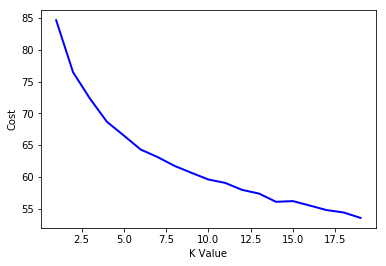

In [38]:
cs_grouped_clustering = cs_grouped.drop('Station ID', 1)

cost = [] 
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(cs_grouped_clustering)

    # calculates squared error for the clustered points 
    cost.append(kmeans.inertia_)

# plot the cost against K values 
plt.plot(range(1, 20), cost, color ='b', linewidth ='2') 
plt.xlabel("K Value") 
plt.ylabel("Cost") 
plt.show()

The elbow, or location on the above plot where the slope starts to decrease, is at a K Value of 6, so we'll run k-means to group the charging stations into 6 clusters.

In [39]:
kclusters = 6 # set number of clusters

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cs_grouped_clustering)

# check first 20 cluster labels generated for each row (charging station) in the dataframe
kmeans.labels_[0:20]

array([1, 3, 0, 2, 3, 3, 0, 3, 0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 3],
      dtype=int32)

In [40]:
len(kmeans.labels_) # Should be the same as the # of rows in the cs_grouped DataFrame

798

Now let's create a new DataFrame that includes the cluster as well as the top 10 venues for each charging station. Note that we do a right join because there are (2, as of March 27, 2020 run) fewer rows (charging stations) in the clustered venues DataFrame than in the original DataFrame, since not all charging stations had a venue within 400 meters.

In [41]:
# add clustering labels
cs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cs_merged = df_cs

# merge 10 most common venues DataFrame with original charging stations DataFrame
cs_merged = cs_merged.join(cs_venues_sorted.set_index('Station ID'), on='id', how='right')

cs_merged.head()

,id,station_name,latitude,longitude,street_address,city,state,zip,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,101972,FAIRFIELD INN - Tesla Supercharger,34.785416,-86.942864,21282 Athens-Limestone Blvd.,Athens,AL,35613,1,Fast Food Restaurant,American Restaurant,Hotel,Intersection,Ice Cream Shop,Breakfast Spot,Coffee Shop,Pizza Place,Bakery,Food Stand
1,101973,Auburn Mall - Tesla Supercharger,32.627837,-85.445105,1627 Opelika Road,Auburn,AL,36830,3,Department Store,Clothing Store,Women's Store,Lingerie Store,Mobile Phone Shop,Discount Store,Fast Food Restaurant,Shopping Mall,Seafood Restaurant,Chinese Restaurant
2,101974,Uptown Entertainment District - Tesla Supercha...,33.525826,-86.807072,2221 Richard Arrington Junior Blvd.,Birmingham,AL,35203,0,Hotel,Pizza Place,Coffee Shop,Gym / Fitness Center,Brazilian Restaurant,Pub,Fried Chicken Joint,Museum,Burger Joint,Mexican Restaurant
3,101975,Hampton Inn Greenville - Tesla Supercharger,31.855989,-86.635765,219 Interstate Drive,Greenville,AL,36037,2,Hotel,Gym / Fitness Center,American Restaurant,Mobile Phone Shop,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
4,101976,The Bel Air Mall - Tesla Supercharger,30.671556,-88.118644,3201 Airport Blvd,Mobile,AL,36606,3,Clothing Store,Shoe Store,Department Store,Bakery,Lingerie Store,Kids Store,Discount Store,Cosmetics Shop,Convenience Store,Fast Food Restaurant


## Create map to visualize the resuling clusters

Get latitude and longitude for the United States.

In [42]:
g = geocoder.arcgis('United States')
us_latitude = g.latlng[0]
us_longitude = g.latlng[1]

Each cluster is represented by a separate color. Cluster examination and overviews are in sections subsequent to the map.

In [64]:
# create map
map_clusters = folium.Map(location=[us_latitude, us_longitude], tiles='Stamen Terrain', zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map for each charging station with nearby venues
markers_colors = []
for lat, lon, poi, cluster, street, city, state, zipcode in \
    zip(cs_merged['latitude'], cs_merged['longitude'], cs_merged['station_name'], cs_merged['Cluster Labels'], \
        cs_merged['street_address'], cs_merged['city'], cs_merged['state'], cs_merged['zip']):
    label = folium.Popup(poi + ', Cluster ' + str(cluster + 1) + ', ' + \
                         street + ', ' + city + ', ' + state + ' ' + zipcode, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

## Let's examine each of the 6 clusters.
The heading for each cluster below indicates the color of the corresponding dots on the above map, along with a general summary of the type of charging stations within the cluster, based on the predominant venues within that cluster.

### Cluster 1 (Violet): Hotels, Restaurants, Shopping, Banks

In [44]:
cs_merged.loc[cs_merged['Cluster Labels'] == 0, cs_merged.columns[[1] + list(range(8, cs_merged.shape[1]))]]

,station_name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Uptown Entertainment District - Tesla Supercha...,0,Hotel,Pizza Place,Coffee Shop,Gym / Fitness Center,Brazilian Restaurant,Pub,Fried Chicken Joint,Museum,Burger Joint,Mexican Restaurant
6,Love's Travel Stop - Tesla Supercharger,0,Intersection,Fried Chicken Joint,Gas Station,Sandwich Place,Truck Stop,Fish Market,Fabric Shop,Falafel Restaurant,Farm,Farmers Market
8,Carl's Jr. - Sundance Towne Center - Tesla Sup...,0,Fast Food Restaurant,Pizza Place,Thrift / Vintage Store,Convenience Store,Mexican Restaurant,Shipping Store,Bank,Hardware Store,Sandwich Place,Clothing Store
15,Biltmore Fashion Park - Tesla Supercharger,0,Coffee Shop,Cosmetics Shop,Clothing Store,New American Restaurant,Lounge,Department Store,American Restaurant,Burger Joint,Shopping Mall,Bank
16,Deer Valley Town Center - Tesla Supercharger,0,Sandwich Place,Cosmetics Shop,Pizza Place,Clothing Store,Noodle House,Asian Restaurant,Furniture / Home Store,Mexican Restaurant,Shopping Plaza,Coffee Shop
18,Scottsdale Quarter - Tesla Supercharger,0,Furniture / Home Store,American Restaurant,Mexican Restaurant,Clothing Store,Cosmetics Shop,Steakhouse,Pizza Place,Breakfast Spot,Beach Bar,Candy Store
21,Holiday Inn Express - Tesla Supercharger,0,Fried Chicken Joint,Gas Station,American Restaurant,Sandwich Place,Fishing Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
22,Hilton Garden Inn/ Pivot Point Conference Cent...,0,Park,Border Crossing,Bar,Coffee Shop,History Museum,Gift Shop,German Restaurant,Hotel,Art Gallery,Café
23,Rabobank - Tesla Supercharger,0,Fast Food Restaurant,Coffee Shop,Pizza Place,Brewery,Donut Shop,Park,Movie Theater,City Hall,Salon / Barbershop,Mexican Restaurant
24,Baker Shell - Tesla Supercharger,0,Ice Cream Shop,Frozen Yogurt Shop,Bubble Tea Shop,Gas Station,Food Service,Sandwich Place,Breakfast Spot,Dim Sum Restaurant,Flower Shop,Farmers Market


### Cluster 2 (Blue): Fast Food

In [45]:
cs_merged.loc[cs_merged['Cluster Labels'] == 1, cs_merged.columns[[1] + list(range(8, cs_merged.shape[1]))]]

,station_name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,FAIRFIELD INN - Tesla Supercharger,1,Fast Food Restaurant,American Restaurant,Hotel,Intersection,Ice Cream Shop,Breakfast Spot,Coffee Shop,Pizza Place,Bakery,Food Stand
9,Culver's - Tesla Supercharger,1,Fast Food Restaurant,Bank,Pharmacy,Salon / Barbershop,Donut Shop,Sandwich Place,Mobile Phone Shop,Coffee Shop,Warehouse Store,Breakfast Spot
11,Burger King Holbrook - Tesla Supercharger,1,Mexican Restaurant,Fast Food Restaurant,Campground,Food,Convenience Store,Video Store,Flea Market,Farm,Farmers Market,Filipino Restaurant
12,Carl's Jr. Kingman - Tesla Supercharger,1,Fast Food Restaurant,RV Park,American Restaurant,Taco Place,Art Museum,Hotel,Convenience Store,Restaurant,Motel,Food Court
13,Shell & Subway Travel Center - Tesla Supercharger,1,Gas Station,Intersection,Tourist Information Center,Fast Food Restaurant,Diner,Discount Store,Sandwich Place,Fishing Spot,Falafel Restaurant,Farm
17,Carl's Jr. - Quartzsite - Tesla Supercharger,1,Fast Food Restaurant,Flea Market,Jewelry Store,Gift Shop,Sandwich Place,Discount Store,Truck Stop,American Restaurant,Fried Chicken Joint,Snack Place
20,Shell Gas Station and Convenience Store - Tesl...,1,Intersection,Sandwich Place,Fast Food Restaurant,Hotel,Food Truck,Fish & Chips Shop,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm
33,Rabobank Corning - Tesla Supercharger,1,Hotel,Pizza Place,Fast Food Restaurant,RV Park,Pharmacy,Coffee Shop,Sandwich Place,Burger Joint,Gas Station,Mexican Restaurant
34,Crescent City Downtown Parking - Tesla Superch...,1,Fast Food Restaurant,Deli / Bodega,Tourist Information Center,Motel,Grocery Store,Thai Restaurant,Bank,Chinese Restaurant,Breakfast Spot,Dive Bar
57,Inyokern Market - Tesla Supercharger,1,Fast Food Restaurant,Motel,Gas Station,Mexican Restaurant,Zoo,Flea Market,Farm,Farmers Market,Filipino Restaurant,Financial or Legal Service


### Cluster 3 (Turqoise): Hotels & Restaurants

In [46]:
cs_merged.loc[cs_merged['Cluster Labels'] == 2, cs_merged.columns[[1] + list(range(8, cs_merged.shape[1]))]]

,station_name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Hampton Inn Greenville - Tesla Supercharger,2,Hotel,Gym / Fitness Center,American Restaurant,Mobile Phone Shop,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
10,Courtyard Marriott Flagstaff - Tesla Supercharger,2,Hotel,ATM,Burger Joint,Mobile Phone Shop,Mexican Restaurant,Big Box Store,Shipping Store,Sandwich Place,Pizza Place,Sporting Goods Shop
14,Courtyard Page at Lake Powell - Tesla Supercha...,2,Hotel,Hotel Pool,Boat or Ferry,Golf Course,American Restaurant,Fish & Chips Shop,Flea Market,Fishing Store,Fishing Spot,Fish Market
25,Easy Trip Food Store - Tesla Supercharger,2,Hotel,Sandwich Place,Breakfast Spot,Fast Food Restaurant,Gas Station,Fishing Store,Falafel Restaurant,Farm,Farmers Market,Filipino Restaurant
27,Santa Ynez Valley Marriott - Tesla Supercharger,2,Hotel,Fast Food Restaurant,Chinese Restaurant,Gas Station,Burger Joint,Coffee Shop,Fishing Store,Falafel Restaurant,Farm,Farmers Market
44,Tenaya Lodge - Tesla Supercharger,2,American Restaurant,Hotel,Trail,Deli / Bodega,Gym,Athletics & Sports,Gift Shop,Pizza Place,Gym Pool,Pool
49,Tesla Fremont Delivery - Tesla Supercharger,2,Hotel,Gym / Fitness Center,Sandwich Place,Bus Stop,Fishing Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
70,Westside Shell - Tesla Supercharger,2,Hotel,Restaurant,Chinese Restaurant,Ice Cream Shop,Hotel Pool,Sandwich Place,Fast Food Restaurant,Gas Station,Farmers Market,Fish Market
74,Hilton Garden Inn Redondo Beach - Tesla Superc...,2,Hotel,Intersection,Burger Joint,Light Rail Station,Electronics Store,Bus Stop,IT Services,Theme Restaurant,Food Service,Fish & Chips Shop
103,Hampton Inn & Suites Denver/Airport-Gateway Pa...,2,Hotel,American Restaurant,Steakhouse,Coffee Shop,Pizza Place,Bagel Shop,Gym,Thai Restaurant,Liquor Store,Farm


### Cluster 4 (Green): Clothing Stores

In [47]:
cs_merged.loc[cs_merged['Cluster Labels'] == 3, cs_merged.columns[[1] + list(range(8, cs_merged.shape[1]))]]

,station_name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Auburn Mall - Tesla Supercharger,3,Department Store,Clothing Store,Women's Store,Lingerie Store,Mobile Phone Shop,Discount Store,Fast Food Restaurant,Shopping Mall,Seafood Restaurant,Chinese Restaurant
4,The Bel Air Mall - Tesla Supercharger,3,Clothing Store,Shoe Store,Department Store,Bakery,Lingerie Store,Kids Store,Discount Store,Cosmetics Shop,Convenience Store,Fast Food Restaurant
5,Oxford Exchange - Tesla Supercharger,3,Clothing Store,Mobile Phone Shop,Department Store,Electronics Store,Shoe Store,Sporting Goods Shop,Shopping Mall,Paper / Office Supplies Store,Southern / Soul Food Restaurant,Fabric Shop
7,Outlets of Little Rock - Tesla Supercharger,3,Clothing Store,Outlet Store,Sporting Goods Shop,Hotel,Movie Theater,Steakhouse,Chocolate Shop,Gourmet Shop,Shoe Store,Sandwich Place
19,La Encantada - Tesla Supercharger,3,Women's Store,Cosmetics Shop,Clothing Store,Furniture / Home Store,Boutique,Jewelry Store,American Restaurant,Lingerie Store,Accessories Store,Supermarket
26,Ayres Hotel Barstow - Tesla Supercharger,3,Clothing Store,Accessories Store,Fast Food Restaurant,Breakfast Spot,Shoe Store,Burger Joint,Sandwich Place,Coffee Shop,Convenience Store,Outlet Store
28,Burbank Town Center - Tesla Supercharger,3,Clothing Store,Coffee Shop,Pizza Place,Ice Cream Shop,Sandwich Place,Burger Joint,Furniture / Home Store,Shoe Store,Convenience Store,Asian Restaurant
30,Desert Hills Premium Outlets - Tesla Supercharger,3,Clothing Store,Shoe Store,Outlet Store,Accessories Store,Department Store,Luggage Store,Fast Food Restaurant,Smoothie Shop,Coffee Shop,Food
32,The Veranda - Tesla Supercharger,3,Clothing Store,Cosmetics Shop,Gift Shop,American Restaurant,Shoe Store,Coffee Shop,Department Store,Toy / Game Store,Discount Store,Mobile Phone Shop
35,Westfield Culver City - Tesla Supercharger,3,Cosmetics Shop,Clothing Store,Mexican Restaurant,Snack Place,Ice Cream Shop,Women's Store,Lingerie Store,Bakery,Grocery Store,Tea Room


### Cluster 5 (Orange): Convenience Stores, Zoos, Farms

In [48]:
cs_merged.loc[cs_merged['Cluster Labels'] == 4, cs_merged.columns[[1] + list(range(8, cs_merged.shape[1]))]]

,station_name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,Allied Clean Fuels - Tesla Supercharger,4,Convenience Store,Zoo,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fireworks Store
113,Connecticut Welcome Center - Tesla Supercharger,4,Convenience Store,Rest Area,Squash Court,Italian Restaurant,Sandwich Place,Fast Food Restaurant,Donut Shop,Zoo,Fish Market,Fish & Chips Shop
134,Wawa - Tesla Supercharger,4,History Museum,Auto Dealership,Convenience Store,Arts & Entertainment,Zoo,Fishing Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
321,Stewart’s Shop - Tesla Supercharger,4,Farm,Trail,Pet Store,Convenience Store,Construction & Landscaping,Zoo,Fishing Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant
329,125 Victory Hwy - Tesla Supercharger,4,Donut Shop,Convenience Store,Shopping Mall,Park,Breakfast Spot,Forest,Fishing Spot,Falafel Restaurant,Farm,Farmers Market
357,Lucille's Road House - Tesla Supercharger,4,Gym,American Restaurant,Convenience Store,Zoo,Flea Market,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service
360,Detroit Lake - Tesla Supercharger,4,Harbor / Marina,Café,Convenience Store,American Restaurant,Hotel,BBQ Joint,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Farm
414,Amigos Country Corner and Travel Center - Tesl...,4,BBQ Joint,Gift Shop,Convenience Store,Mexican Restaurant,Forest,Fishing Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
445,Wawa - Tesla Supercharger,4,Hotel,Discount Store,Accessories Store,Convenience Store,Flea Market,Fishing Store,Fishing Spot,Fish Market,Fish & Chips Shop,Zoo
457,Maplewood Convenience Store/Comfort Inn - Tesl...,4,Hotel,American Restaurant,Grocery Store,Convenience Store,Zoo,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant


### Cluster 6 (Red): Gas Stations, Zoos, Farms, Filipino Restaurants

In [49]:
cs_merged.loc[cs_merged['Cluster Labels'] == 5, cs_merged.columns[[1] + list(range(8, cs_merged.shape[1]))]]

,station_name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
376,"Sheetz, Inc. - Tesla Supercharger",5,Gas Station,Breakfast Spot,Zoo,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service
528,Flying J Travel Center - Tesla Supercharger,5,Gas Station,Fast Food Restaurant,Bus Station,Sandwich Place,Mexican Restaurant,Zoo,Fishing Store,Falafel Restaurant,Farm,Farmers Market
663,Sheetz - Tesla Supercharger,5,Gas Station,Zoo,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fireworks Store
747,Texas Best Smokehouse - Tesla Supercharger,5,Gas Station,Intersection,Fast Food Restaurant,Discount Store,Flower Shop,Farm,Farmers Market,Filipino Restaurant,Financial or Legal Service,Fireworks Store
772,Miccosukee Service Plaza - Tesla Supercharger,5,Gas Station,Zoo,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fireworks Store


## Finally, let's create a bar chart to illustrate cluster sizes along with their categorizations.

Create a dictionary containing the cluster labels as the keys and the cluster sizes as the values.

In [51]:
a = np.array(kmeans.labels_)
unique, counts = np.unique(a, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
cluster_sizes

{0: 464, 1: 103, 2: 82, 3: 121, 4: 23, 5: 5}

Create the bar chart, with each bar being the same color as the corresponding cluster members on the map.

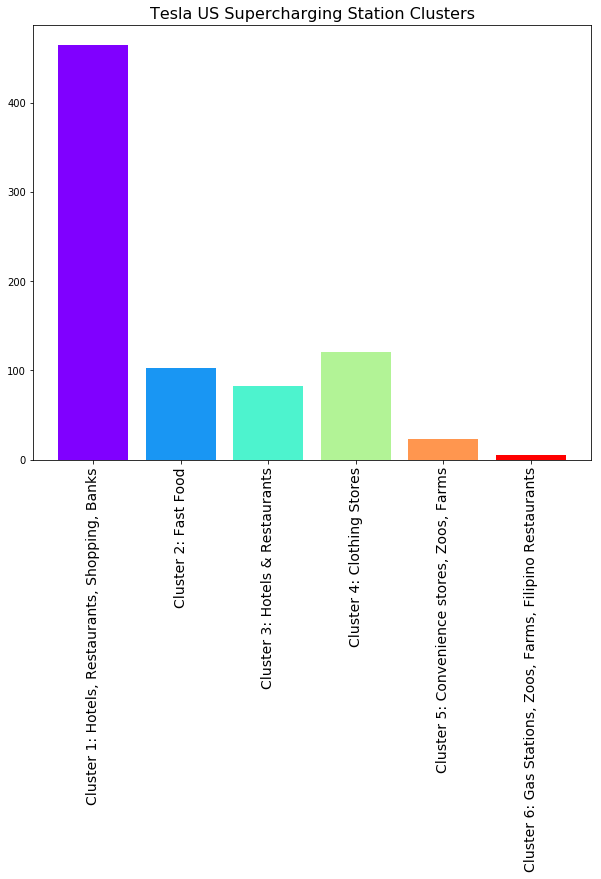

In [54]:
fig, ax = plt.subplots(figsize=[10,8])

width = 0.8          # the width of the bars
ax.bar(list(cluster_sizes.keys()), list(cluster_sizes.values()), width, color=rainbow)
ax.set_xticks(np.arange(kclusters))
ax.set_xticklabels(['Cluster 1: Hotels, Restaurants, Shopping, Banks',\
    'Cluster 2: Fast Food',\
    'Cluster 3: Hotels & Restaurants',\
    'Cluster 4: Clothing Stores',\
    'Cluster 5: Convenience stores, Zoos, Farms',\
    'Cluster 6: Gas Stations, Zoos, Farms, Filipino Restaurants'], rotation=90, fontsize=14)
ax.set_title('Tesla US Supercharging Station Clusters', {'fontsize':16})

plt.show()